# Building a Handwritten Digits Classifier

We'll explore the effectiveness of deep, feedforward neural networks at classifying images. In particular we will look at a handwritten digits classifier.

In [32]:
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

digits = load_digits()

digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [33]:
labels = pd.Series(digits['target'])
data = pd.DataFrame(digits['data'])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


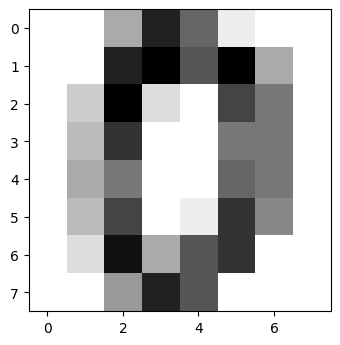

In [34]:
image = data.iloc[0].values.reshape(8,8)

plt.imshow(image, cmap='gray_r')

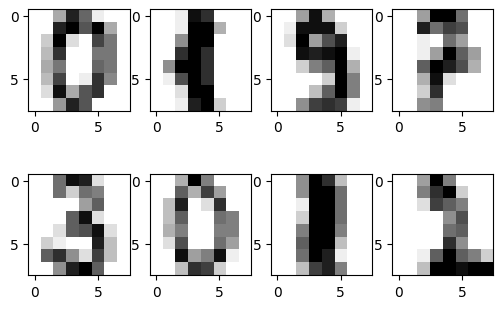

In [35]:
# Generate subplots
f, axarr = plt.subplots(2, 4)

# Images for 0,100,200,300
axarr[0, 0].imshow(data.iloc[0].values.reshape(8,8), cmap='gray_r')
axarr[0, 1].imshow(data.iloc[99].values.reshape(8,8), cmap='gray_r')
axarr[0, 2].imshow(data.iloc[199].values.reshape(8,8), cmap='gray_r')
axarr[0, 3].imshow(data.iloc[299].values.reshape(8,8), cmap='gray_r')

# Images for 1000,1100,1200,1300
axarr[1, 0].imshow(data.iloc[999].values.reshape(8,8), cmap='gray_r')
axarr[1, 1].imshow(data.iloc[1099].values.reshape(8,8), cmap='gray_r')
axarr[1, 2].imshow(data.iloc[1199].values.reshape(8,8), cmap='gray_r')
axarr[1, 3].imshow(data.iloc[1299].values.reshape(8,8), cmap='gray_r')

## K-Nearest Neighbors Model

Since linear and logistic regression models make assumptions about the linearity between features and output labels, we should use the k-nearest neighbors algorithm to capture the nonlinearity in the data.

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# 50% Train / test validation for KNN
def train(nneighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train(k, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

k_vals = []
for k in range(1,10):
    k_vals.append(np.mean(cross_validate(k)))
    
np.mean(k_vals)

0.9841120184772747

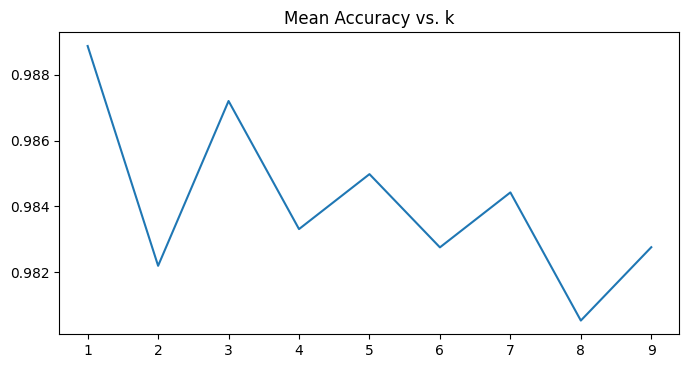

In [37]:
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. k")
plt.plot(range(1,10),k_vals)

As we can see above, the accuracy decreases with a higher k. It also has high memory usage and no model representation to debug and explore. Thus, we will now look at using a neural network.

## Neural Network with One Hidden Layer

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# 50% Train / test validation for NN
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes = neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

# test() is the same

@ignore_warnings(category=ConvergenceWarning)
def cross_validate_nn(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies
    

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.



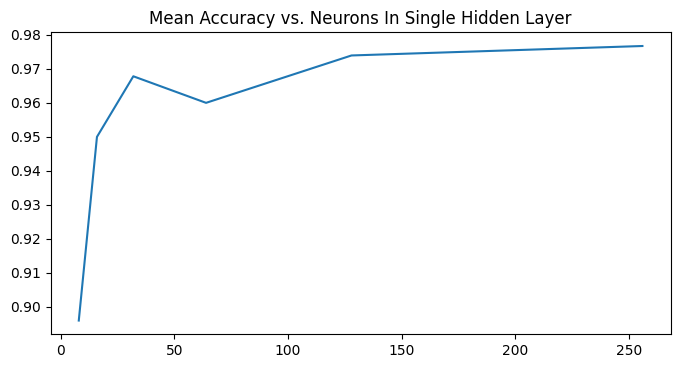

In [39]:
# Single hidden layer of differing sizes
nn_neurons = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,)
]
nn_accuracies = []

for n in nn_neurons:
    nn_accuracies.append(np.mean(cross_validate_nn(n)))

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Single Hidden Layer")

x = [i[0] for i in nn_neurons]
plt.plot(x, nn_accuracies)

Adding more neurons to the single hidden layer improved the accuracy to about 97%. However, it is the simple accuracy, so we are currently unsure about false or true positives or false or true negatives. This would be something to look further into.

Overall, using a single hidden layer neural network doesn't improve accuracy past the k-nearest neighbors. Using more layers may improve accuracy.

## Neural Network with Two Hidden Layers

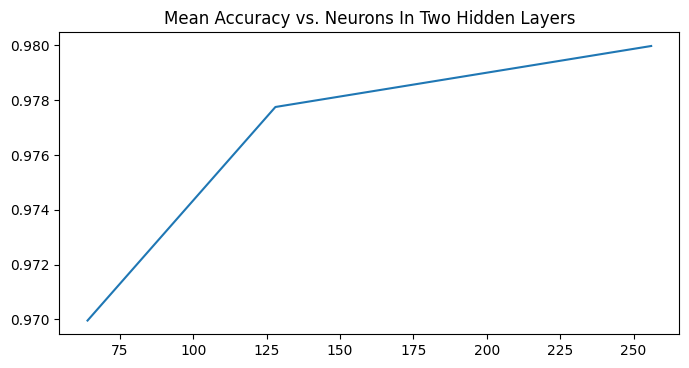

In [41]:
# Two layers
nn_two_neurons = [
    (64,64),
    (128, 128),
    (256, 256)
]
nn_two_accuracies = []

for n in nn_two_neurons:
    nn_two_accuracies.append(np.mean(cross_validate_nn(n)))

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Two Hidden Layers")

x = [i[0] for i in nn_two_neurons]
plt.plot(x, nn_two_accuracies)

With two hidden layers, it seems that accuracy is improving. Maybe using three layers might help. In doing so, we run the risk of overfitting, so we will be using 6-fold cross validation.

## Neural Network with Three Hidden Layers

In [45]:
@ignore_warnings(category=ConvergenceWarning)
def cross_validate_six(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 6, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

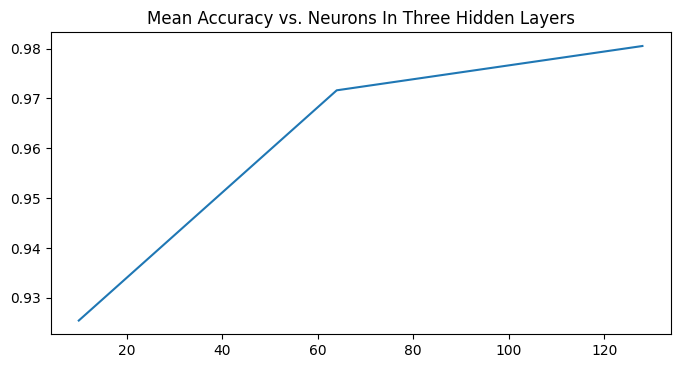

In [46]:
# Three layers
nn_three_neurons = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128)
]

nn_three_accuracies = []

for n in nn_three_neurons:
    nn_accuracies = cross_validate_six(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_three_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layers")

x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_accuracies)

With three hidden layers, we can see simple accuracy reaching 98% and possibly going higher with more neurons. With a 